In [1]:
from dem.energies.tblite_energy import TBLiteEnergy
import numpy as np
import pickle
import torch 
from dem.energies.base_energy_function import BaseEnergyFunction
from dem.energies.lennardjones_energy import LennardJonesEnergy 
from dem.models.components.clipper import Clipper
from dem.models.components.noise_schedules import BaseNoiseSchedule, GeometricNoiseSchedule
from dem.models.components.score_estimator import get_logreward_noised_samples

#  Make dataset for cyclic peptides idem

In [1]:
import numpy as np

data = np.load('data/test_split_LJ13-1000.npy')
data.shape

(10000, 39)

In [4]:
from Bio import PDB
import numpy as np
import periodictable

def get_atomicnumber(max_Z = 50):
    '''Maps the atomic number to the atom elements in the periodic table.'''
    atom2atomicnumber = {}
    atomicnumber2atom = {}
    for atomicnumber in range(max_Z):
        element = periodictable.elements[atomicnumber + 1] 
        atom2atomicnumber[element.symbol] = atomicnumber + 1
        atomicnumber2atom[atomicnumber + 1] = element.symbol
    return atom2atomicnumber, atomicnumber2atom


def extract_column_from_pdb(pdb_path, start, end):
    column_data = []
    with open(pdb_path, 'r') as pdb_file:
        for line in pdb_file:
            if line.startswith('ENDMDL'):
                break
            if line.startswith('ATOM'):
                column_value = line[start:end].strip() 
                column_data.append(column_value)
    return column_data

def get_coord(model):
    '''Extracts the coordinates of the atoms in the model.'''
    coords = []
    for chain in model:
        for residue in chain:
            for atom in residue:
                x,y,z = atom.get_coord()
                coords.append([x,y,z])
    return np.array(coords).flatten()


def get_models_atoms(pdb_path ):
    '''Extracts the models and atom ids from the pdb file.'''
    atom2atomicnumber, _ = get_atomicnumber()
    parser = PDB.PDBParser()
    io = PDB.PDBIO()
    struct = parser.get_structure('structure_id',f'{pdb_path}')
    atom_names = []
    models = list(struct.get_models())
    atom_names = extract_column_from_pdb(f'{pdb_path}', 77, 78)
    atom_ids = np.array([atom2atomicnumber[x] for x in atom_names ])
    return models, atom_ids

def get_coords(pdb_path):
    models, atom_ids = get_models_atoms(pdb_path)
    coords = []
    for model in models:
        coords.append(get_coord(model))
    return np.array(coords)


In [5]:
pdb_path = '/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/T.I.f.V.pdb'
coords = get_coords(pdb_path)
coords.shape

(283, 207)

In [6]:
coords_train, coords_val = np.array([]), coords
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_train.npy', coords_train)
np.save('/home/mila/l/lena-nehale.ezzine/Amgen/DEM/data/TIfV_val.npy', coords_val)


# TorchANI on a cyclic peptide

In [25]:
import numpy as np
import pickle
import torch
from dem.energies.torchani_energy import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
coords = torch.tensor(np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy'), dtype=torch.float32).to(device).view(-1,69,3).requires_grad_(True)
atom_ids = torch.Tensor(pickle.load(open('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/atom_ids.pkl', 'rb'))).to(device).long().unsqueeze(0)
energy_function = TorchaniEnergy(dimensionality = 3*69, n_particles = 69, is_molecule=True, data_path ='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy',   data_path_train='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_train.npy', data_path_val='/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/TIfV_val.npy', T=0.1, device= device)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


Let's compare the torchANI-energy distribution for conformations optimized using GFN2xtb, vs random conformations. If they are the same, torchANI is not a good proxy for GFN2xtb.

In [30]:
test_data_logrews =  - energy_function(coords)
rand_coords = 3*torch.randn_like(coords)
random_data_logrews =  - energy_function(rand_coords)

/tmp/ipykernel_972023/2685235816.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in dict_data.keys() ])


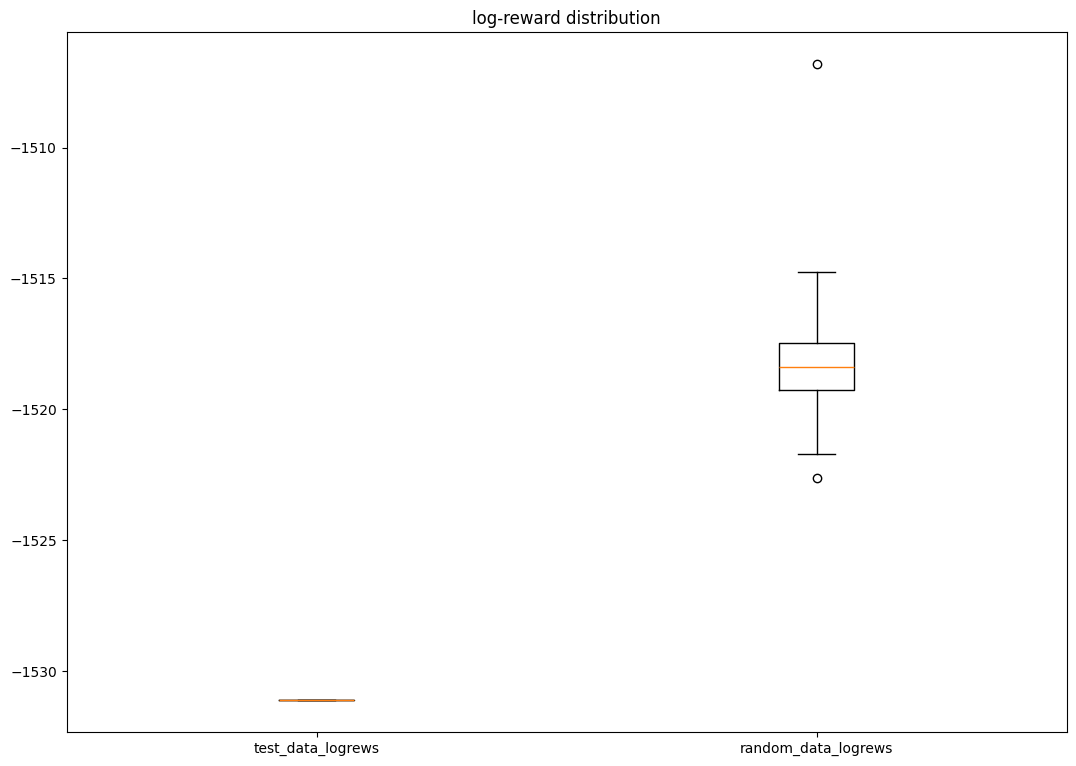

In [31]:
import matplotlib.pyplot as plt

dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() , 'random_data_logrews':  random_data_logrews.detach().cpu()}
data = [x for x in dict_data.values()]
 
fig = plt.figure(figsize =(10, 7)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title('log-reward distribution')
# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()

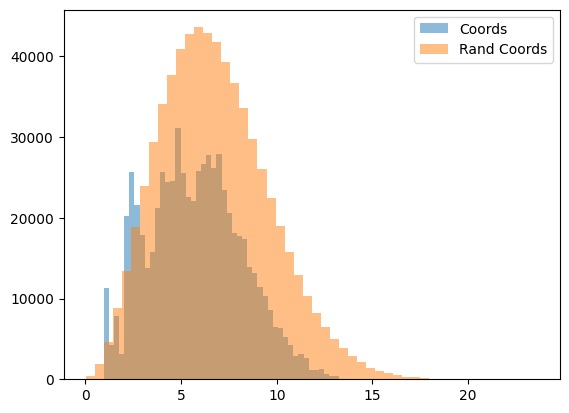

In [38]:
plt.hist(energy_function.interatomic_dist(coords).flatten().detach().cpu(),bins = 50, label='Coords', alpha=0.5)
plt.hist(energy_function.interatomic_dist(rand_coords).flatten().detach().cpu(),bins = 50, label='Rand Coords', alpha=0.5)
plt.legend()
plt.show()

In [39]:
import numpy as np
lj13_coords = np.load('/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/data/test_split_LJ13-1000.npy')

In [41]:
#TODO : fix bug
#plt.hist(energy_function.interatomic_dist(lj13_coords).flatten(),bins = 50)

# GEOM-Drugs dataset exploration

In [1]:
import numpy as np
import pickle
import torch
import json
import torchani
import periodictable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/aev.py:16: UserWarning: cuaev not installed
  warnings.warn("cuaev not installed")
/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/__init__.py:55: UserWarning: Dependency not satisfied, torchani.ase will not be available
  warnings.warn("Dependency not satisfied, torchani.ase will not be available")


In [2]:
#read json file
with open('/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/summary_qm9.json') as json_file:

    summary = json.load(json_file)

In [3]:
import pandas as pd 
pd.DataFrame(summary).T.sort_values(by='uniqueconfs', ascending=False)

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/zoneinfo/_tzpath.py:44: InvalidTZPathWarning: Invalid paths specified in PYTHONTZPATH environment variable. Paths should be absolute but found the following relative paths:
    y/envs/dem/share/zoneinfo
    y/envs/dem/share/tzinfo
  warnings.warn(


,charge,ensembleenergy,ensembleentropy,ensemblefreeenergy,lowestenergy,pickle_path,poplowestpct,temperature,totalconfs,uniqueconfs
[O]C(=O)[C@H]1C[C@]21CC[NH2]2,0,0.756,10.418,-3.106,-28.41889,qm9/[O]C(=O)[C@H]1C[C@]21CC[NH2]2.pickle,11.333,298.15,2078,1614
O=C([O])[C@H]1[C@H]2C[C@@H]1[NH2]C2,0,0.98,10.156,-3.028,-28.4571,qm9/O=C([O])[C@H]1[C@H]2C[C@@H]1[NH2]C2.pickle,12.603,298.15,1786,1357
CCOCCCCCO,0,1.204,10.677,-3.183,-31.275,qm9/CCOCCCCCO.pickle,10.611,298.15,1381,1101
N#N.[NH][C][N]C=O,0,1.781,13.261,-3.954,-20.94522,qm9/N#N.[NH][C][N]C=O.pickle,5.1,298.15,1447,1088
OCCCCCCCO,0,1.419,12.241,-3.65,-31.27486,qm9/OCCCCCCCO.pickle,2.311,298.15,1294,1073
...,...,...,...,...,...,...,...,...,...,...
C[C@H]1[C@H]2[C@@H]3[C@H]4C=C[C@@]13N24,0,0.0,2.183,-0.651,-24.47926,qm9/C[C@H]1[C@H]2[C@@H]3[C@H]4C=C[C@@]13N24.pi...,100.0,298.15,3,1
C[C@H]1[C@H]2[C@@H]3[C@H]4CC[C@@]13N24,0,0.0,2.183,-0.651,-25.55615,qm9/C[C@H]1[C@H]2[C@@H]3[C@H]4CC[C@@]13N24.pickle,100.0,298.15,3,1
C[C@H]1[C@H]2[C@@H]3[C@H]4CC[C@@]13[C@@H]24,0,0.0,2.183,-0.651,-25.29723,qm9/C[C@H]1[C@H]2[C@@H]3[C@H]4CC[C@@]13[C@@H]2...,100.0,298.15,3,1
n1nnon1,0,0.0,0.0,0.0,-15.60444,qm9/n1nnon1.pickle,100.0,298.15,1,1


In [15]:
import pickle
#load pickle file
smiles = 'CCOCCCCCO'
with open(f'/home/mila/l/lena-nehale.ezzine/scratch/geomdrugs/rdkit_folder/qm9/{smiles}.pickle', 'rb') as f:
    mol = pickle.load(f) 

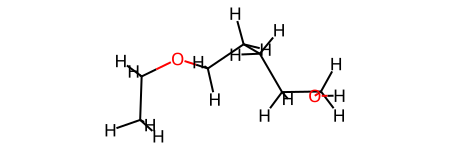

In [23]:
mol['conformers'][1000]['rd_mol']

In [18]:
summary[smiles]

{'charge': 0,
 'ensembleenergy': 1.204,
 'ensembleentropy': 10.677,
 'ensemblefreeenergy': -3.183,
 'lowestenergy': -31.275,
 'pickle_path': 'qm9/CCOCCCCCO.pickle',
 'poplowestpct': 10.611,
 'temperature': 298.15,
 'totalconfs': 1381,
 'uniqueconfs': 1101}

In [7]:
def get_coords(mol, device = device, requires_grad = True):
    coords = []
    for i in range(len(mol['conformers'])):
        x = mol['conformers'][i]['rd_mol'].GetConformer().GetPositions()
        coords.append(x)
    coords = torch.Tensor(coords).to(device).requires_grad_(requires_grad)
    return coords

def get_atom_ids(mol, device = device):
    atoms = np.array([atom.GetSymbol() for atom in mol['conformers'][0]['rd_mol'].GetAtoms()])
    atom_ids = [getattr(periodictable, symbol).number for symbol in atoms]
    atom_ids = torch.Tensor(atom_ids).to(device).long().unsqueeze(0)
    return atom_ids


def interatomic_dist(x):
    # Compute the pairwise interatomic distances
    # removes duplicates and diagonal
    distances = x[:, None, :, :] - x[:, :, None, :]
    distances = distances[
        :,
        torch.triu(torch.ones((x.shape[1], x.shape[1])), diagonal=1)
        == 1,
    ]
    dist = torch.linalg.norm(distances, dim=-1)
    return dist

coords = get_coords(mol)
atom_ids = get_atom_ids(mol)
print(coords.shape, atom_ids)


torch.Size([1614, 18, 3]) tensor([[8, 6, 8, 6, 6, 6, 1, 1, 6, 1, 1, 6, 1, 1, 7, 1, 1, 1]],
       device='cuda:0')


/tmp/ipykernel_972023/445202615.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  coords = torch.Tensor(coords).to(device).requires_grad_(requires_grad)


(array([7.4016e+04, 6.8916e+04, 3.2730e+04, 4.9780e+03, 9.3300e+02,
        1.7160e+03, 2.8830e+03, 3.8940e+03, 3.8640e+03, 3.5940e+03,
        3.3750e+03, 2.7510e+03, 2.6130e+03, 2.4590e+03, 2.2800e+03,
        2.2820e+03, 2.2170e+03, 2.0510e+03, 1.9980e+03, 1.6700e+03,
        1.6740e+03, 1.5560e+03, 1.3890e+03, 1.1400e+03, 9.7300e+02,
        8.4700e+02, 8.5000e+02, 7.8400e+02, 8.0200e+02, 8.3000e+02,
        8.6300e+02, 7.8200e+02, 7.2100e+02, 7.5500e+02, 6.3200e+02,
        5.6300e+02, 5.4100e+02, 4.4500e+02, 4.1800e+02, 4.0300e+02,
        3.1800e+02, 2.9700e+02, 3.6600e+02, 1.0420e+03, 1.8730e+03,
        2.2580e+03, 1.6420e+03, 7.5000e+02, 1.8800e+02, 2.0000e+01]),
 array([ 1.01320899,  2.54644251,  4.07967567,  5.61290932,  7.14614296,
         8.6793766 , 10.21260929, 11.74584293, 13.27907658, 14.81231022,
        16.34554291, 17.87877655, 19.41201019, 20.94524384, 22.47847748,
        24.01171112, 25.54494476, 27.07817841, 28.61141014, 30.14464378,
        31.67787743, 33.21

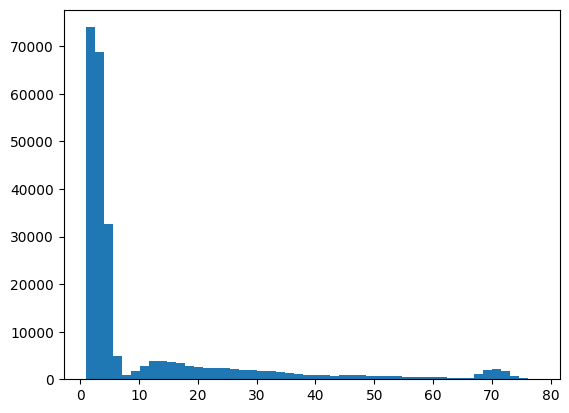

In [12]:
import matplotlib.pyplot as plt
dists = interatomic_dist(coords).detach().cpu().numpy()
plt.hist(dists.flatten(), bins=50)

For torchANI, energies are in Hartree. but in the GEOM dataset, they are in  Kcal / mol, and 1Kcal / mol = 627.509 Hartree.


(array([5.900e+01, 1.780e+02, 4.730e+02, 7.270e+02, 1.122e+03, 1.484e+03,
        2.079e+03, 2.551e+03, 2.972e+03, 3.512e+03, 4.042e+03, 4.364e+03,
        4.946e+03, 5.580e+03, 5.846e+03, 6.095e+03, 6.441e+03, 6.713e+03,
        6.811e+03, 7.020e+03, 6.993e+03, 6.947e+03, 6.932e+03, 6.725e+03,
        6.620e+03, 6.295e+03, 5.976e+03, 5.595e+03, 5.075e+03, 4.515e+03,
        3.992e+03, 3.191e+03, 2.668e+03, 2.159e+03, 1.637e+03, 1.337e+03,
        1.002e+03, 7.390e+02, 5.510e+02, 3.990e+02, 2.380e+02, 1.770e+02,
        8.300e+01, 6.400e+01, 3.900e+01, 2.000e+01, 8.000e+00, 5.000e+00,
        2.000e+00, 1.000e+00]),
 array([0.01081583, 0.04250164, 0.07418744, 0.10587325, 0.13755906,
        0.16924486, 0.20093067, 0.23261647, 0.26430228, 0.29598808,
        0.32767388, 0.35935968, 0.39104551, 0.42273131, 0.45441711,
        0.48610291, 0.51778871, 0.54947454, 0.58116037, 0.61284614,
        0.64453197, 0.67621773, 0.70790356, 0.73958939, 0.77127516,
        0.80296099, 0.83464676, 0.86

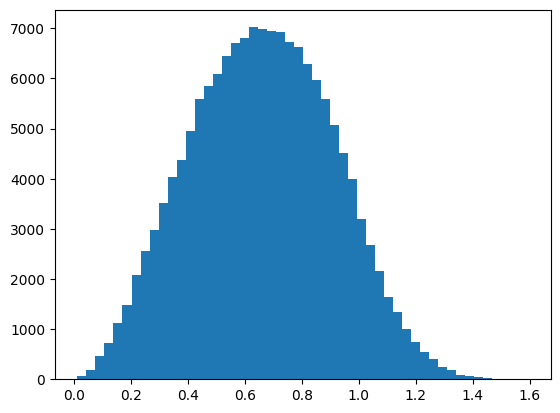

In [13]:
n_rand = 1000
rand_coords = 1*torch.rand(n_rand,coords.shape[1],coords.shape[2]).to(coords.device)
rand_dists = interatomic_dist(rand_coords).detach().cpu().numpy()
plt.hist(rand_dists.flatten(), bins=50)

TODO : redraw these histograms but for distances instead of coords

/home/mila/l/lena-nehale.ezzine/Amgen/DEM_fork/y/envs/dem/lib/python3.10/site-packages/torchani/resources/


/tmp/ipykernel_972023/2349178838.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x for x in dict_data.keys() ])


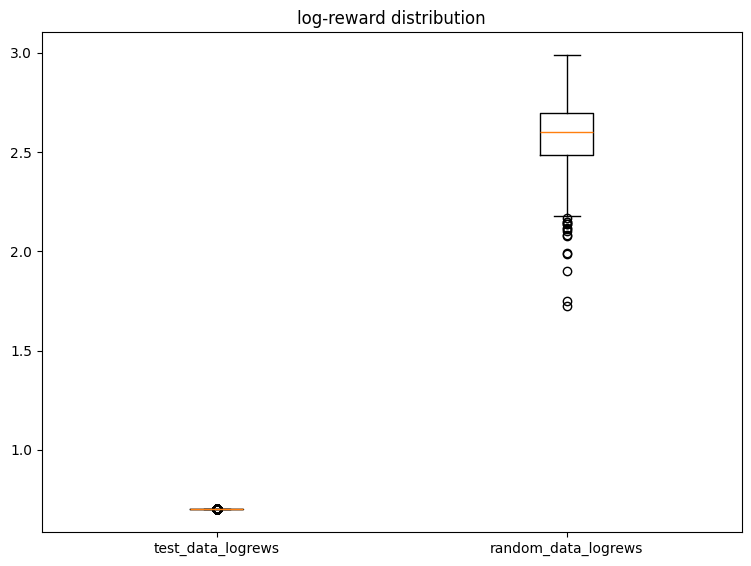

In [24]:
model = torchani.models.ANI2x(periodic_table_index=True).to(device)
test_data_logrews = - model((atom_ids.repeat(len(coords),1), coords)).energies / 627.509 
random_data_logrews = - model((atom_ids.repeat(n_rand,1), rand_coords )).energies / 627.509
dict_data = {'test_data_logrews': test_data_logrews.detach().cpu() , 'random_data_logrews':  random_data_logrews.detach().cpu()}
data = [x for x in dict_data.values()]
fig = plt.figure(figsize =(7, 5)) 
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels([x for x in dict_data.keys() ])
ax.set_title('log-reward distribution')
# Creating plot
bp = ax.boxplot(data)

# show plot
plt.show()
